In [ ]:
!pip install contractions
!pip install textblob
!pip install emoji
!pip install regex
!pip install demoji
!pip install pyLDAvis==2.1.2
!pip install tdqm
!pip install ipython==7.10.0
!pip install gensim

In [ ]:
#try 2.1.2 for pyLDAvis
# 2.0.0
# 1.5.1

In [ ]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.figure_factory as ff

import re
import emoji 
import demoji
import contractions
from tqdm import tqdm

#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


In [35]:
#Read and convert csv files to data frames
# before_war = pd.read_csv("before_war.csv")
war_and_after = pd.read_csv("war_and_afterwards.csv")

In [24]:
'''
This function removes stopwords, tokenizes the text, and performs other basic text processing.
I used the emoji and demoji libraries to extract the meaning of the emojis to achieve a more accurate sentiment score.
The cleaned text will be stored in another column called cleaned_text.
I also used Vader to calculate the sentiment score of each tweet (-1 = negative, 1 = positive)
# '''

from tqdm import tqdm  # Import tqdm library

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Set up stopwords
stop_words = set(stopwords.words('english'))

# Clean the text data
def clean_text(text):
    #Remove any links via re
    text = re.sub(r'http\S+', ' ', text)

    #Account for contractions like I've
#     text = contractions.fix(text)

    #Convert emojis to text
    text = emoji.demojize(text, delimiters=(" "," ")) 

    #Only accept alphabetical chars after processing emojis
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    #Tokenize text and make everything lowercase
    tokens = word_tokenize(text.lower())

    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    #Rejoin the tokens into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

tqdm.pandas()

#Clean the 'text' column and save cleaned text as 'cleaned_text'
# before_war['cleaned_text'] = before_war.apply(clean_text, axis=1)
# war_and_after['cleaned_text'] = war_and_after.apply(clean_text, axis=1)
# Clean the 'text' column and save cleaned text as 'cleaned_text'
war_and_after['cleaned_text'] = war_and_after['text'].progress_apply(clean_text)

                                            
#Apply VADER sentiment analysis to the 'text' columns in both datasets
# before_war['sentiment_score'] = before_war['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
war_and_after['sentiment_score'] = war_and_after['cleaned_text'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])


100%|██████████| 8268526/8268526 [55:47<00:00, 2470.09it/s]  


In [ ]:
#change 'date' column to 'datetime' type
# before_war['date'] = pd.to_datetime(before_war['date'], format='%Y-%m-%d') 
# war_and_after['date'] = pd.to_datetime(before_war['date'], format='%Y-%m-%d') 


#pickle files
# before_war_cleaned = before_war
# war_and_after_cleaned = war_and_after
# with open('before_war_cleaned.pkl', 'wb') as f:
#     pickle.dump(before_war_cleaned, f)
    
# with open('war_and_after_cleaned.pkl', 'wb') as f:
#     pickle.dump(war_and_after_cleaned, f)

with open('before_war_cleaned.pkl', 'rb') as f:
    before_war = pickle.load(f)
    print(before_war.shape)

with open('war_and_after_cleaned.pkl', 'rb') as f:
    war_and_after = pickle.load(f)
    print(war_and_after.shape)



In [ ]:
#Frequency of Posts by Year-Month

ym2 = before_war['date'].value_counts().sort_index() # get the counts for each year-month and sort them
plt.figure(figsize=(20,6))
sns.lineplot(x=ym2.index, y = ym2.values, color='green') # plot the line chart using seaborn
plt.title('Distribution of Tweets Before War', fontsize=15)

ym = war_and_after['date'].value_counts().sort_index() # get the counts for each year-month and sort them
plt.figure(figsize=(20,6))
sns.lineplot(x=ym.index, y = ym.values, color='green') # plot the line chart using seaborn
plt.title('Year-Month distribution of tweets', fontsize=15)

In [16]:
#Get TF-IDF of before_war
#Convert text into matrix of token counts.
before_war_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.85,
                                min_df = 5,
                                ngram_range=(2,4))

#Tokenize the text data and conver tot sparse matrix representation 
#(doc index, token index in vocab)  count of token in doc  
before_war_tfidf = before_war_vect.fit_transform(before_war['cleaned_text'])
print(before_war_tfidf.shape)

(835142, 5000)


In [17]:
#Convert text into matrix of token counts.
war_and_after_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=10000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.95,
                                min_df = 10,
                                ngram_range=(2,4))
#Tokenize the text data and convert to sparse matrix representation 
#(doc index, token index in vocab)  count of token in doc  
war_and_after_tfidf = war_and_after_vect.fit_transform(war_and_after['cleaned_text'])
print(war_and_after_tfidf.shape)

(8268526, 10000)


In [30]:
#pickle 
# with open('before_war_tfidf.pkl', 'wb') as f:
#     pickle.dump(before_war_tfidf, f)
    
# with open('war_and_after_tfidf.pkl', 'wb') as f:
#     pickle.dump(war_and_after_tfidf, f)


(835142, 5000)
(8268526, 10000)


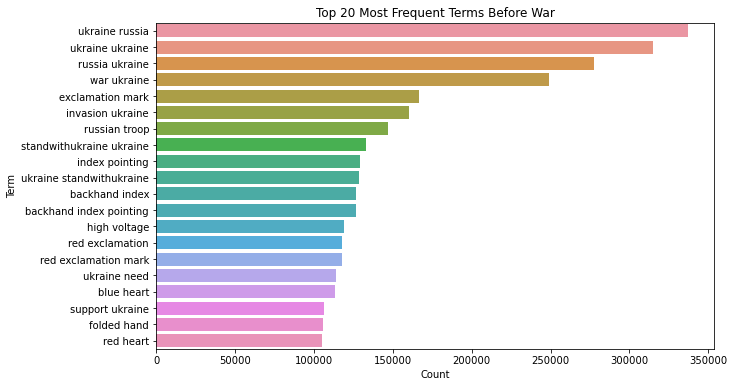

In [166]:
#Most frequent words in before_war

# Combine the counts of each token across all tweets
token_counts_before_war = np.array(before_war_tfidf.sum(axis=0))[0]

# Get indices of sorted token counts 
sorted_indices = np.argsort(token_counts)[::-1]

# Get unique terms/token from extracted text (vocab)from CountVectorizer
vocab_before_war = before_war_vect.get_feature_names()

# Get the most frequent terms and their counts
term_freq_before_war = [(vocab[i], token_counts[i]) for i in sorted_indices]

# Convert the most frequent terms to a DataFrame for visualization
most_frequent_df = pd.DataFrame(most_frequent_terms, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20))  # Adjust the number to display more or fewer terms
plt.title('Top 20 Most Frequent Terms Before War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


In [ ]:
#Most frequent words in before_war

# Combine the counts of each token across all tweets
token_counts_before_war = np.array(war_and_after_tfidf.sum(axis=0))[0]

# Get indices of sorted token counts 
sorted_indices = np.argsort(token_counts)[::-1]

# Get unique terms/token from extracted text (vocab)from CountVectorizer
vocab = war_and_after_vect.get_feature_names()

# Get the most frequent terms and their counts
term_freq_war_and_after = [(vocab[i], token_counts[i]) for i in sorted_indices]

# Convert the most frequent terms to a DataFrame for visualization
most_frequent_df = pd.DataFrame(most_frequent_terms, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20))  # Adjust the number to display more or fewer terms
plt.title('Top 20 Most Frequent Terms During War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


In [ ]:
#LDA topic modeling on before_war


#elbow method for optimal number of clusters--> research
before_war_lda = LatentDirichletAllocation(n_components=10,
                                   max_iter=200,
                                   learning_method='online',
                                   random_state = 0)


before_war_lda.fit(before_war_tfidf)

#LDA topic modeling on before_war
before_war_lda2 = LatentDirichletAllocation(n_components=6,
                                   max_iter=200,
                                   learning_method='online',
                                   random_state = 0)
before_war_lda2.fit(before_war_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=200,
                          n_components=6, random_state=0)

In [119]:
#Pickle before_war LDAs
# with open('before_war_lda.pkl', 'wb') as f:
#     pickle.dump(before_war_lda, f)
# with open('before_war_lda2.pkl', 'wb') as f:
#     pickle.dump(before_war_lda2, f)

#Pickle war_and_after LDA
# with open('before_war_lda.pkl', 'wb') as f:
#     pickle.dump(before_war_lda, f)
# with open('before_war_lda2.pkl', 'wb') as f:
#     pickle.dump(before_war_lda2, f)


#Pickle war_and_after LDAs
# with open('war_and_after_lda2.pkl', 'wb') as f:
#     pickle.dump(war_and_after_lda2, f)
# with open('war_and_after_lda.pkl', 'wb') as f:
#     pickle.dump(war_and_after_lda, f)

# #Read pickled after_war_LDAs
# # with open('war_and_after_lda.pkl', 'rb') as f:
# #     war_and_after_lda = pickle.load(f)
with open('war_and_after_lda2.pkl', 'rb') as f:
    war_and_after_lda2 = pickle.load(f)


#Read pickled vects
# with open('before_war_tfidf.pkl', 'rb') as f:
#     before_war_tfidf = pickle.load(f)
#     print(before_war_tfidf.shape)
# with open('war_and_after_tfidf.pkl', 'rb') as f:
#     war_and_after_tfidf = pickle.load(f)
#     print(war_and_after_tfidf.shape)

In [161]:
#get top 10 words from the 10 clusters
n_top_words = 10
tf_feature_names = before_war_vect.get_feature_names()

topics = dict()
for topic_idx, topic in enumerate(before_war_lda.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #0:
twitter com | eastern ukraine | russian troop | troop eastern ukraine | troop ukrainian | separatist region | russian border | ukrainian border | russian army | border russia
Topic #1:
vladimir putin | russian president | president vladimir | president vladimir putin | russian president vladimir | russian president vladimir putin | russian military | com news | putin order | region ukraine
Topic #2:
russian troop | ukraine border | russian soldier | border russian | troop near ukraine | president putin | ukraine nato | russian tank | russian troop near ukraine | military force
Topic #3:
russian troop | troop border | russian troop border | border ukraine | sending troop | president biden | troop border ukraine | com world | say russian | russian aggression
Topic #4:
russian troop | troop enter | russian troop enter | thousand russian | troop enter ukraine | russian troop enter ukraine | thousand russian troop | border ukraine | putin order russian troop | send russian troop
T

In [201]:
#get topic-term distribution matrix from LDA:
before_war_topic_term = before_war_lda.components_
#get topic-document distribution matrix. Each row=document, column = topic, entry= prob of document belonging to topic
before_war_doc_topic_dist = before_war_lda.transform(before_war_tfidf)
#get document lengths (list or array containing lengths of each document in corpus)
before_war_doc_lengths = np.array(before_war_tfidf.sum(axis=1)).squeeze()
#combine the counts of each token across all tweets
before_war_token_counts = np.array(before_war_tfidf.sum(axis=0))[0]
#get unique terms/token from extracted text (vocab)from CountVectorizer
before_war_vocab = before_war_vect.get_feature_names()


#tokenize each document in 'cleaned_text'
# tokenized_documents = [document.split() for document in before_war['cleaned_text']]
# dictionary = Dictionary(tokenized_documents)
# dictionary.filter_extremes(no_below=10, no_above=0.95)
# #convert prepcoressed content into bag of words format
# corpora = [dictionary.doc2bow(doc) for doc in tokenized_documents]

#Pickle each object
# with open('before_war_topic_term.pkl', 'wb') as f:
#     pickle.dump(before_war_topic_term, f)
# with open('before_war_doc_topic_dist.pkl', 'wb') as f:
#     pickle.dump(before_war_doc_topic_dist, f)
    
# with open('before_war_doc_lengths.pkl', 'wb') as f:
#     pickle.dump(before_war_doc_lengths, f)
    
# with open('before_war_token_counts.pkl', 'wb') as f:
#     pickle.dump(before_war_token_counts, f)
    
# with open('before_war_vocab.pkl', 'wb') as f:
#     pickle.dump(before_war_vocab, f)


# with open('before_war_topic_term.pkl', 'rb') as f:
#     before_war_topic_term=pickle.load(f)
    
# with open('before_war_doc_topic_dist.pkl', 'rb') as f:
#     before_war_doc_topic_dist=pickle.load(f)

# with open('before_war_doc_lengths.pkl', 'rb') as f:
#     before_war_doc_lengths=pickle.load(f)
    
# with open('before_war_token_counts.pkl', 'rb') as f:
#     before_war_token_counts=pickle.load(f)
    
# with open('before_war_vocab.pkl', 'rb') as f:
#    before_war_vocab=pickle.load(f)

In [227]:
# before_war_topic_term = before_war_lda.components_
# before_war_doc_topic_dist = before_war_lda.transform(before_war_tfidf)
# before_war_doc_lengths = np.array(before_war_tfidf.sum(axis=1)).squeeze()
# before_war_token_counts = np.array(before_war_tfidf.sum(axis=0))[0]
# before_war_vocab = before_war_vect.get_feature_names()


pyLDAvis.sklearn.prepare(before_war_topic_term, before_war_doc_topic_dist, before_war_doc_lengths, before_war_vocab, before_war_token_counts)
# doc_topic_sum = np.sum(before_war_doc_topic_dist, axis=1)
# doc_topic_valid = np.allclose(doc_topic_sum, 1.0)
# print("Topic-term distribution matrix valid: ",doc_topic_valid )

# print("before_war_topic_term: ", before_war_topic_term.shape)




Topic-term distribution matrix valid:  False
Topic-term distribution matrix valid:  True
before_war_topic_term:  (10, 5000)
before_war_doc_topic_dist:  (835142, 10)


In [ ]:


#visualize intertopic distance map
# pyLDAvis.sklearn.prepare(topic_term_before_war, before_war_tfidf, before_war_vect, vocab_before_war, term_freq_before_war)


In [ ]:
pip show joblib

In [142]:
n_top_words = 5
tf_feature_names = before_war_vect.get_feature_names()

topics = dict()
for topic_idx, topic in enumerate(before_war_lda2.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #0:
russia invade | twitter com | invasion ukraine | russian invasion | sending troop
Topic #1:
ukraine border | troop ukraine | russian troop | troop ukraine border | near ukraine
Topic #2:
united state | russian troop | world war | russia ukraine | ukraine nato
Topic #3:
war ukraine | ukraine russia | border ukraine | troop border | russian troop
Topic #4:
invade ukraine | russia invade ukraine | ukraine nato | join nato | ukraine join
Topic #5:
russia ukraine | war russia | com news | ukraine war | ukraine crisis


In [ ]:
#LDA topic modeling on war_and_after

#10 topics
# war_and_after_lda = LatentDirichletAllocation(n_components=10,
#                                    max_iter=200,
#                                    learning_method='online',
#                                    random_state = 0)
# war_and_after_lda.fit(war_and_after_tfidf)

from tqdm import tqdm

# # Initialize LDA model
# war_and_after_lda = LatentDirichletAllocation(n_components=10,
#                                                max_iter=200,
#                                                learning_method='online',
#                                                random_state=0)

# # Initialize progress bar
# progress_bar = tqdm(total=war_and_after_lda.max_iter)

# # Fit LDA model with progress bar
# for iteration in range(war_and_after_lda.max_iter):
#     war_and_after_lda.partial_fit(war_and_after_tfidf)
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()


#For 6 topics
# war_and_after_lda = LatentDirichletAllocation(n_components=6,
#                                    max_iter=200,
#                                    learning_method='online',
#                                    random_state = 0)
# war_and_after_lda.fit(war_and_after_tfidf)

# Initialize LDA model
war_and_after_lda2 = LatentDirichletAllocation(n_components=6,
                                               max_iter=200,
                                               learning_method='online',
                                               random_state=0)

# Initialize progress bar
progress_bar = tqdm(total=war_and_after_lda2.max_iter)

# Fit LDA model with progress bar
for iteration in range(war_and_after_lda2.max_iter):
    war_and_after_lda2.partial_fit(war_and_after_tfidf)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

In [121]:
n_top_words = 5
tf_feature_names = war_and_after_vect.get_feature_names()
print("After War 10 Clusters: ")
topics = dict()
for topic_idx, topic in enumerate(war_and_after_lda2.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

After War 10 Clusters: 
Topic #0:
war ukraine | ukraine russian | ukraine ukraineunderattack | people ukraine | ukrainerussianwar ukraine
Topic #1:
blue heart | support ukraine | yellow heart | russian soldier | heart yellow
Topic #2:
ukraine russia | russia ukraine | ukraine ukraine | folded hand | ukraine ukrainerussiawar
Topic #3:
ukraine need | russian troop | innocent civilian | ukrainian force | putin stop
Topic #4:
ukraine ukraine | exclamation mark | red exclamation | red exclamation mark | high voltage
Topic #5:
invasion ukraine | index pointing | backhand index pointing | backhand index | standwithukraine ukraine


In [98]:
#

LatentDirichletAllocation(learning_method='online', max_iter=200,
                          n_components=5, random_state=0)